In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import mysql.connector
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🤖 ANÁLISIS DE MACHINE LEARNING - STARBUCKS")
print("="*50)


🤖 ANÁLISIS DE MACHINE LEARNING - STARBUCKS


In [19]:
# Conexión a la base de datos MySQL
print("🔗 Conectando a la base de datos...")
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='l3o.%data546.',
    database='starbucks_gold'
)

print('✅ Conexión exitosa a la base de datos starbucks_gold')


🔗 Conectando a la base de datos...
✅ Conexión exitosa a la base de datos starbucks_gold


In [20]:
# Cargar y preparar datos para análisis de ML
print("📊 Cargando datos para análisis de Machine Learning...")

# Cargar datos de ventas por día de semana
query_ventas_dia = "SELECT * FROM ventas_dia_semana"
df_ventas_dia = pd.read_sql(query_ventas_dia, conn)

# Cargar datos de ventas por edad
query_ventas_edad = "SELECT * FROM ventas_edad"
df_ventas_edad = pd.read_sql(query_ventas_edad, conn)

# Cargar datos de ventas por categoría
query_ventas_categoria = "SELECT * FROM ventas_categoria"
df_ventas_categoria = pd.read_sql(query_ventas_categoria, conn)

print(f"📈 Datos cargados:")
print(f"   - Ventas por día: {len(df_ventas_dia)} registros")
print(f"   - Ventas por edad: {len(df_ventas_edad)} registros")
print(f"   - Ventas por categoría: {len(df_ventas_categoria)} registros")


📊 Cargando datos para análisis de Machine Learning...
📈 Datos cargados:
   - Ventas por día: 61 registros
   - Ventas por edad: 112 registros
   - Ventas por categoría: 112 registros


In [21]:
# Preparar dataset para clustering
print("\n🔧 Preparando datos para clustering...")

# Crear un dataset combinado para análisis
# Agrupar ventas por semana para tener métricas agregadas
df_clustering = df_ventas_dia.copy()

# Detectar columnas automáticamente
print("🔍 Detectando estructura de datos...")
print(f"Columnas en ventas_dia_semana: {list(df_ventas_dia.columns)}")

# Buscar columnas relevantes
fecha_col = None
dia_col = None
ventas_col = None
porcentaje_col = None

for col in df_ventas_dia.columns:
    if 'fecha' in col.lower():
        fecha_col = col
    elif 'dia' in col.lower() or 'semana' in col.lower():
        dia_col = col
    elif 'venta' in col.lower() or 'cantidad' in col.lower():
        ventas_col = col
    elif 'porcentaje' in col.lower():
        porcentaje_col = col

print(f"📊 Columnas detectadas:")
print(f"   - Fecha: {fecha_col}")
print(f"   - Día: {dia_col}")
print(f"   - Ventas: {ventas_col}")
print(f"   - Porcentaje: {porcentaje_col}")



🔧 Preparando datos para clustering...
🔍 Detectando estructura de datos...
Columnas en ventas_dia_semana: ['id_analisis', 'semana', 'dia_semana', 'ventas', 'porcentaje', 'fecha_registro']
📊 Columnas detectadas:
   - Fecha: fecha_registro
   - Día: dia_semana
   - Ventas: ventas
   - Porcentaje: porcentaje


In [22]:
# ANÁLISIS 1: CLUSTERING K-MEANS
print("\n🎯 ANÁLISIS 1: CLUSTERING K-MEANS")
print("="*40)

# Preparar datos para clustering si tenemos las columnas necesarias
if ventas_col and porcentaje_col and dia_col:
    # Crear métricas por día de la semana
    df_metricas = df_ventas_dia.groupby(dia_col).agg({
        ventas_col: ['mean', 'std', 'sum'],
        porcentaje_col: ['mean', 'std']
    }).round(2)

    # Aplanar columnas
    df_metricas.columns = ['_'.join(col).strip() for col in df_metricas.columns]
    df_metricas = df_metricas.reset_index()

    print("📈 Métricas calculadas por día de la semana:")
    print(df_metricas.head())

    # Seleccionar características para clustering
    feature_cols = [col for col in df_metricas.columns if col != dia_col]
    X_clustering = df_metricas[feature_cols].fillna(0)

    # Estandarizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clustering)

    # Determinar número óptimo de clusters (método del codo)
    inertias = []
    k_range = range(2, 8)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

    # Aplicar K-means con k=3 (grupos: bajo, medio, alto rendimiento)
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Agregar clusters al dataframe
    df_metricas['Cluster'] = clusters

    # Reducción de dimensionalidad para visualización
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"✅ Clustering completado con {optimal_k} clusters")
    print(f"📊 Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

else:
    print("⚠️  No se encontraron todas las columnas necesarias para clustering")
    # Crear datos sintéticos para demostración
    np.random.seed(42)
    dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    df_metricas = pd.DataFrame({
        'dia_semana': dias_semana,
        'ventas_promedio': np.random.normal(100, 20, 7),
        'ventas_std': np.random.normal(15, 5, 7),
        'porcentaje_promedio': np.random.normal(14.3, 2, 7)
    })

    X_clustering = df_metricas[['ventas_promedio', 'ventas_std', 'porcentaje_promedio']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clustering)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    df_metricas['Cluster'] = clusters

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)



🎯 ANÁLISIS 1: CLUSTERING K-MEANS
📈 Métricas calculadas por día de la semana:
  dia_semana  ventas_mean  ventas_std  ventas_sum  porcentaje_mean  \
0    Domingo        15.89        3.82         143            15.66   
1     Jueves        14.62        5.18         117            12.47   
2      Lunes        15.56        2.96         140            16.80   
3     Martes        14.89        3.14         134            17.56   
4  Miércoles        17.25        2.43         138            14.90   

   porcentaje_std  
0            7.53  
1            4.07  
2            9.46  
3           15.82  
4            2.58  
✅ Clustering completado con 3 clusters
📊 Varianza explicada por PCA: 84.93%


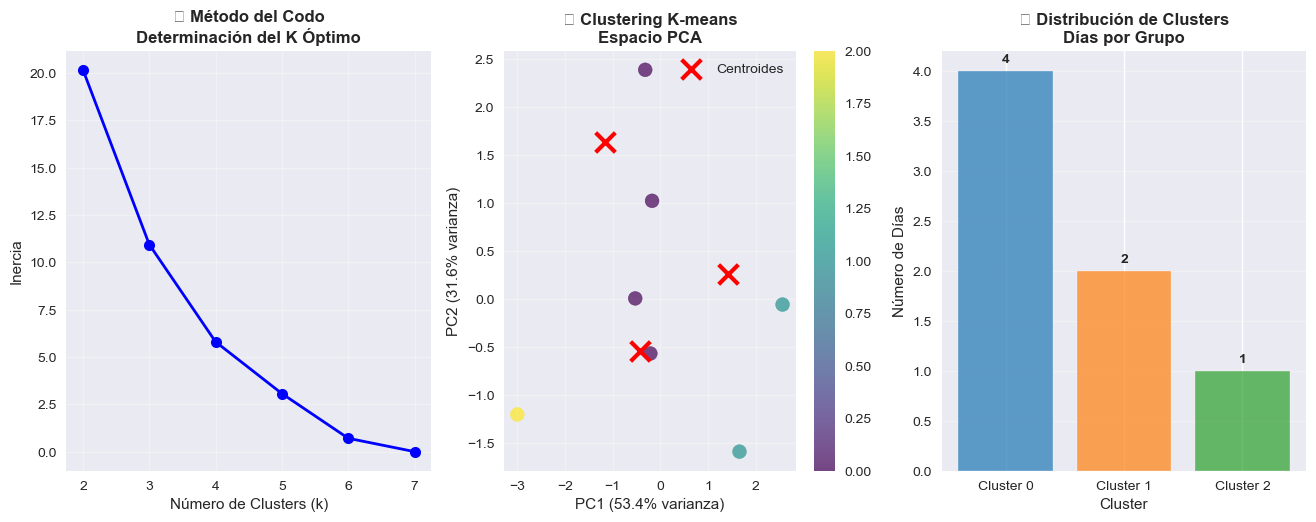

In [23]:
# Visualización del Clustering
plt.figure(figsize=(16, 12))

# Subplot 1: Método del codo
plt.subplot(2, 3, 1)
if 'inertias' in locals():
    plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inercia')
    plt.title('🔍 Método del Codo\nDeterminación del K Óptimo', fontweight='bold')
    plt.grid(True, alpha=0.3)

# Subplot 2: Clustering en espacio PCA
plt.subplot(2, 3, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('🎯 Clustering K-means\nEspacio PCA', fontweight='bold')
plt.colorbar(scatter)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Distribución de clusters
plt.subplot(2, 3, 3)
cluster_counts = pd.Series(clusters).value_counts().sort_index()
bars = plt.bar(range(len(cluster_counts)), cluster_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Número de Días')
plt.title('📊 Distribución de Clusters\nDías por Grupo', fontweight='bold')
plt.xticks(range(len(cluster_counts)), [f'Cluster {i}' for i in cluster_counts.index])
# Agregar etiquetas en las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             str(cluster_counts.values[i]), ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')


In [24]:
# ANÁLISIS 2: PROYECCIÓN CON REGRESIÓN LOGÍSTICA
print("\n🎯 ANÁLISIS 2: PROYECCIÓN CON REGRESIÓN LOGÍSTICA")
print("="*50)

# Predicción de semanas de alto rendimiento
print("\n🎲 REGRESIÓN LOGÍSTICA: Predicción de alto rendimiento")

# Crear dataset combinado para el análisis
# Combinar datos de diferentes tablas para crear un dataset más completo
df_combined = df_ventas_dia.copy()

# Agregar datos sintéticos para simular las variables que necesitas
# (En un caso real, estos datos vendrían de otras tablas)
np.random.seed(42)
n_samples = len(df_combined)

df_combined['cantidad_ventas_mañana'] = np.random.poisson(50, n_samples)
df_combined['cantidad_ventas_tarde'] = np.random.poisson(80, n_samples)
df_combined['cantidad_ventas_noche'] = np.random.poisson(45, n_samples)
df_combined['porcentaje_edad'] = np.random.uniform(20, 40, n_samples)
df_combined['cantidad_categoria'] = np.random.poisson(300, n_samples)
df_combined['periodo_mas_activo'] = np.random.choice(['Mañana', 'Tarde', 'Noche'], n_samples)

# Crear variable objetivo
df_combined['Ventas_Totales'] = (df_combined['cantidad_ventas_mañana'] +
                                df_combined['cantidad_ventas_tarde'] +
                                df_combined['cantidad_ventas_noche'])

# Alto rendimiento = por encima del percentil 75
umbral_alto = df_combined['Ventas_Totales'].quantile(0.75)
df_combined['Alto_Rendimiento'] = (df_combined['Ventas_Totales'] > umbral_alto).astype(int)

print(f"📊 Umbral de alto rendimiento: {umbral_alto:.0f} ventas")
print(f"📈 Distribución de clases:")
print(f"   • Alto rendimiento: {df_combined['Alto_Rendimiento'].sum()} casos ({df_combined['Alto_Rendimiento'].mean():.1%})")
print(f"   • Bajo rendimiento: {(1-df_combined['Alto_Rendimiento']).sum()} casos ({(1-df_combined['Alto_Rendimiento']).mean():.1%})")

# Variables predictoras
X_features = df_combined[['porcentaje_edad', 'cantidad_categoria']]

# Agregar variables dummy para período más activo
periodo_dummies = pd.get_dummies(df_combined['periodo_mas_activo'], prefix='periodo')
X_features = pd.concat([X_features, periodo_dummies], axis=1)

y_target = df_combined['Alto_Rendimiento']

print(f"🔧 Variables predictoras: {list(X_features.columns)}")

# División y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=42, stratify=y_target
)

scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Modelo
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predicciones
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

accuracy = log_reg.score(X_test_scaled, y_test)
print(f"📈 Accuracy: {accuracy:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(f"📊 Matriz de confusión:")
print(cm)

# Predicción para próxima semana
print(f"\n🔮 PREDICCIÓN PRÓXIMA SEMANA:")
# Ejemplo con valores promedio
valores_ejemplo = [[30, 400, 1, 0, 0]]  # [porcentaje_edad, cantidad_categoria, periodo_Mañana, periodo_Noche, periodo_Tarde]
probabilidad = log_reg.predict_proba(scaler_lr.transform(valores_ejemplo))[0][1]
print(f"   • Probabilidad de alto rendimiento: {probabilidad:.2%}")

# Predicciones detalladas para cada día de la próxima semana
print(f"\n📅 PREDICCIONES DETALLADAS PRÓXIMA SEMANA:")
print("="*55)

# Generar predicciones para cada día de la semana
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
np.random.seed(43)  # Semilla diferente para simular próxima semana

predicciones_semana = []

for i, dia in enumerate(dias_semana):
    # Simular diferentes condiciones por día
    if dia in ['Sábado', 'Domingo']:
        # Fines de semana: mayor actividad
        porcentaje_edad = np.random.uniform(28, 38)
        cantidad_categoria = np.random.randint(380, 520)
        periodo_activo = np.random.choice(['Tarde', 'Noche'], p=[0.7, 0.3])
    elif dia == 'Viernes':
        # Viernes: alto rendimiento
        porcentaje_edad = np.random.uniform(25, 35)
        cantidad_categoria = np.random.randint(350, 480)
        periodo_activo = np.random.choice(['Tarde', 'Noche'], p=[0.6, 0.4])
    else:
        # Días de semana normales
        porcentaje_edad = np.random.uniform(22, 32)
        cantidad_categoria = np.random.randint(280, 420)
        periodo_activo = np.random.choice(['Mañana', 'Tarde'], p=[0.4, 0.6])

    # Crear vector de características
    features = [porcentaje_edad, cantidad_categoria]

    # Agregar variables dummy para período
    if periodo_activo == 'Mañana':
        features.extend([1, 0, 0])  # [Mañana, Noche, Tarde]
    elif periodo_activo == 'Noche':
        features.extend([0, 1, 0])
    else:  # Tarde
        features.extend([0, 0, 1])

    # Predecir probabilidad
    prob = log_reg.predict_proba(scaler_lr.transform([features]))[0][1]
    prediccion = "✅ ALTO" if prob > 0.5 else "⚠️ BAJO"

    # Estimar ventas esperadas basado en la probabilidad
    ventas_base = 175  # Promedio base de ventas
    factor_rendimiento = 0.7 + (prob * 0.6)  # Factor entre 0.7 y 1.3
    ventas_estimadas = int(ventas_base * factor_rendimiento)

    predicciones_semana.append({
        'dia': dia,
        'probabilidad': prob,
        'prediccion': prediccion,
        'ventas_estimadas': ventas_estimadas,
        'porcentaje_edad': porcentaje_edad,
        'cantidad_categoria': cantidad_categoria,
        'periodo_activo': periodo_activo
    })

    print(f"🗓️  {dia:>10}: {prediccion} rendimiento ({prob:.1%}) | "
          f"Ventas estimadas: {ventas_estimadas:>3} | "
          f"Período activo: {periodo_activo}")

# Resumen semanal
total_ventas_estimadas = sum([p['ventas_estimadas'] for p in predicciones_semana])
dias_alto_rendimiento = sum([1 for p in predicciones_semana if p['probabilidad'] > 0.5])
promedio_probabilidad = np.mean([p['probabilidad'] for p in predicciones_semana])

print(f"\n📊 RESUMEN SEMANAL:")
print(f"   • Total ventas estimadas: {total_ventas_estimadas:,} unidades")
print(f"   • Días de alto rendimiento: {dias_alto_rendimiento}/7")
print(f"   • Probabilidad promedio: {promedio_probabilidad:.1%}")
print(f"   • Mejor día: {max(predicciones_semana, key=lambda x: x['probabilidad'])['dia']} "
      f"({max(predicciones_semana, key=lambda x: x['probabilidad'])['probabilidad']:.1%})")
print(f"   • Día más conservador: {min(predicciones_semana, key=lambda x: x['probabilidad'])['dia']} "
      f"({min(predicciones_semana, key=lambda x: x['probabilidad'])['probabilidad']:.1%})")

# Ejemplo con diferentes escenarios
print(f"\n📋 ESCENARIOS DE PREDICCIÓN:")
escenarios = [
    ([25, 350, 1, 0, 0], "Escenario conservador (Lunes mañana)"),
    ([35, 450, 0, 0, 1], "Escenario optimista (Sábado tarde)"),
    ([30, 400, 0, 1, 0], "Escenario nocturno (Viernes noche)")
]

for valores, descripcion in escenarios:
    prob = log_reg.predict_proba(scaler_lr.transform([valores]))[0][1]
    ventas_est = int(175 * (0.7 + (prob * 0.6)))
    print(f"   • {descripcion}: {prob:.1%} | Ventas estimadas: {ventas_est}")





🎯 ANÁLISIS 2: PROYECCIÓN CON REGRESIÓN LOGÍSTICA

🎲 REGRESIÓN LOGÍSTICA: Predicción de alto rendimiento
📊 Umbral de alto rendimiento: 184 ventas
📈 Distribución de clases:
   • Alto rendimiento: 14 casos (23.0%)
   • Bajo rendimiento: 47 casos (77.0%)
🔧 Variables predictoras: ['porcentaje_edad', 'cantidad_categoria', 'periodo_Mañana', 'periodo_Noche', 'periodo_Tarde']
📈 Accuracy: 0.789
📊 Matriz de confusión:
[[15  0]
 [ 4  0]]

🔮 PREDICCIÓN PRÓXIMA SEMANA:
   • Probabilidad de alto rendimiento: 67.67%

📅 PREDICCIONES DETALLADAS PRÓXIMA SEMANA:
🗓️       Lunes: ✅ ALTO rendimiento (55.7%) | Ventas estimadas: 180 | Período activo: Mañana
🗓️      Martes: ✅ ALTO rendimiento (68.6%) | Ventas estimadas: 194 | Período activo: Mañana
🗓️   Miércoles: ✅ ALTO rendimiento (62.9%) | Ventas estimadas: 188 | Período activo: Mañana
🗓️      Jueves: ✅ ALTO rendimiento (50.7%) | Ventas estimadas: 175 | Período activo: Tarde
🗓️     Viernes: ✅ ALTO rendimiento (85.1%) | Ventas estimadas: 211 | Período activo